# Bio-optical Backscattering (BBP) Data Explorer

## This notebook processes and visualizes bio-optical data, specifically backscattering coefficients (bbp), typically derived from oceanographic sensors or satellite data.

### Setup and Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import glob

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

### Load and Prepare Data
### We load the dataset and ensure the temporal and spatial columns are correctly formatted python objects.

In [7]:
# Define the directory containing the BBP files
# os.path.expanduser('~') handles the home directory correctly on Mac/Linux
bbp_dir = os.path.expanduser('~/sedtrap_bbp/data_gom')

# Find all TSV files starting with 'bbp_'
# We use os.path.join for cross-platform compatibility
search_pattern = os.path.join(bbp_dir, 'bbp_*.tsv')
bbp_files = glob.glob(search_pattern)

# Diagnostic Print: If you see 0 files, check if the path printed below is correct
print(f"Searching in: {search_pattern}")
print(f"Files found: {len(bbp_files)}")

# Initialize an empty list to store DataFrames
dfs = []

try:
    # Loop through each file and read it
    for file in bbp_files:
        # Read the TSV file (tab-separated)
        temp_df = pd.read_csv(file, sep='\t')
        dfs.append(temp_df)
    
    # Concatenate all DataFrames into one
    if dfs:
        data = pd.concat(dfs, ignore_index=True)
        
        # Ensure the 'datetime' column is converted to datetime objects
        if 'datetime' in data.columns:
            data['date'] = pd.to_datetime(data['datetime'])
            # Sort the table by datetime ascending
            data = data.sort_values('date').reset_index(drop=True)
        
        print(f"Successfully merged {len(bbp_files)} files.")
        print(f"Total rows in dataset: {len(data)}")
        print(data.head())
    else:
        print("--- ERROR: No matching BBP files found ---")
        print(f"Please verify that the folder '{bbp_dir}' exists and contains .tsv files starting with 'bbp_'.")
        data = pd.DataFrame()

except Exception as e:
    print(f"Error processing files: {e}")


Searching in: /home/enrique.montes@CNS.local/sedtrap_bbp/data_gom/bbp_*.tsv
Files found: 4
Successfully merged 4 files.
Total rows in dataset: 240085
               datetime  bbp_532nm  bbp_700nm                date
0  01-Dec-2022 01:04:55   0.000758   0.000117 2022-12-01 01:04:55
1  01-Dec-2022 01:04:57   0.000902   0.000096 2022-12-01 01:04:57
2  01-Dec-2022 01:04:58   0.000614   0.000075 2022-12-01 01:04:58
3  01-Dec-2022 01:04:59   0.000854   0.000283 2022-12-01 01:04:59
4  01-Dec-2022 01:05:00   0.000710  -0.000008 2022-12-01 01:05:00


### Data Cleaning and Pre-processing
### Handle missing values (NaNs) and filter the data for valid ranges of backscattering coefficients (e.g., bbp > 0).

In [16]:
# --- 1. Check for Duplicate Rows (based on datetime) ---
# This replicates the MATLAB logic: reporting all duplicates and then keeping only unique entries.
if not data.empty:
    # Find all rows that are part of a duplicate set
    # keep=False marks ALL occurrences of a duplicate as True
    duplicate_mask = data.duplicated(subset=['date'], keep=False)
    duplicate_indices = data.index[duplicate_mask].tolist()

    if duplicate_indices:
        print(f"Found {len(duplicate_indices)} total rows that are part of a duplicate set.")
        print(f"The indices of these rows are: {duplicate_indices}")
        
        # Create a new DataFrame containing only the unique rows
        # keep='first' keeps the first occurrence and drops subsequent duplicates
        # This matches MATLAB's [~, unique_indices] = unique(bbp_tbl_raw.datetime)
        data_clean = data.drop_duplicates(subset=['date'], keep='first').reset_index(drop=True)
        
        print(f"The table 'data' had {len(data)} rows.")
        print(f"The table 'data_clean' has {len(data_clean)} rows.")
        data = data_clean
    else:
        print("No duplicate rows based on datetime were found.")

# --- 2. Drop rows missing essential temporal information ---
if not data.empty:
    initial_count = len(data)
    data = data.dropna(subset=['date'])
    if initial_count > len(data):
        print(f"Dropped {initial_count - len(data)} rows with missing dates after cleaning.")

# --- 3. Filter for valid BBP values ---
# Adjust 'bbp_700nm' to match the column name in your merged data
bbp_col = 'bbp_700nm' 
if not data.empty and bbp_col in data.columns:
    valid_mask = data[bbp_col] > 0
    data = data[valid_mask]
    print(f"Final filtered data contains {len(data)} valid records (bbp > 0).")

No duplicate rows based on datetime were found.
Final filtered data contains 191642 valid records (bbp > 0).


### BBP Vertical Profile / Time Series Visualization.
### Visualize how BBP changes over time. This helps in identifying seasonal cycles or specific events.

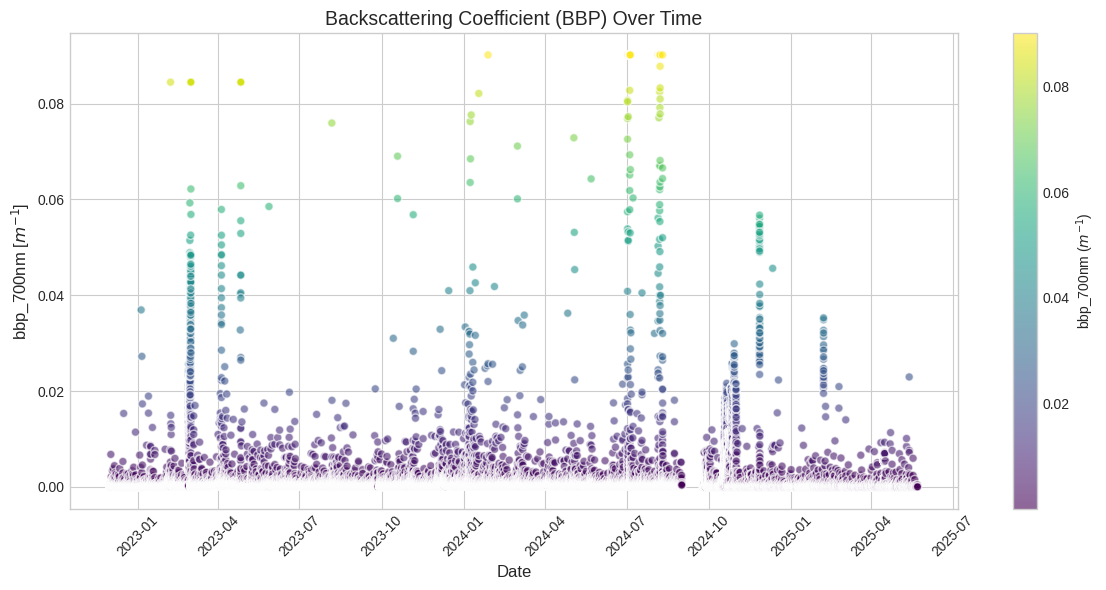

In [17]:
plt.figure(figsize=(12, 6))

# Plotting BBP vs Date
plt.scatter(data['date'], data[bbp_col], c=data[bbp_col], cmap='viridis', alpha=0.6, edgecolors='w')
plt.colorbar(label=f'{bbp_col} ($m^{{-1}}$)')

plt.title('Backscattering Coefficient (BBP) Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel(f'{bbp_col} [$m^{{-1}}$]', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Summary Statistics
### Calculate group statistics (e.g., monthly means) to identify trends.

In [ ]:
# Create a Month-Year column for grouping
data['month_year'] = data['date'].dt.to_period('M')

monthly_summary = data.groupby('month_year')[bbp_col].agg(['mean', 'std', 'count']).reset_index()
monthly_summary['month_year'] = monthly_summary['month_year'].astype(str)

print("Monthly Summary Statistics:")
print(monthly_summary)

### Load and filter sediment trap data


In [20]:
# --- Load Sediment Trap Flux Data ---
try:
    trap_flux_tbl = pd.read_csv('~/sedtrap_bbp/data_gom/trap_flux_gom.csv')
    
    # Ensure Mid_Date is in datetime format
    if 'Mid_Date' in trap_flux_tbl.columns:
        trap_flux_tbl['Mid_Date'] = pd.to_datetime(trap_flux_tbl['Mid_Date'])
        
        # --- Filter by Date ---
        cutoff_date = pd.Timestamp(2022, 12, 1)
        initial_count = len(trap_flux_tbl)
        trap_flux_tbl = trap_flux_tbl[trap_flux_tbl['Mid_Date'] >= cutoff_date].reset_index(drop=True)
        
        print(f"Loaded trap flux data. Excluded {initial_count - len(trap_flux_tbl)} rows before {cutoff_date.date()}.")
        print(f"Remaining rows: {len(trap_flux_tbl)}")
    
    # --- Display Results ---
    print("\nFirst 10 rows of the filtered trap flux table:")
    print(trap_flux_tbl.head(10))

except Exception as e:
    print(f"Error loading sediment trap data: {e}")



First 10 rows of the filtered trap flux table:
   Cup  Duration        Date    Mid-Date  Julian Day  Mid-Julian  \
0    1         7  2021-12-07  2021-12-10        5090      5093.5   
1    2         7  2021-12-14  2021-12-17        5097      5100.5   
2    3        14  2021-12-21  2021-12-28        5104      5111.0   
3    4        14  2022-01-04  2022-01-11        5118      5125.0   
4    5        14  2022-01-18  2022-01-25        5132      5139.0   
5    6        14  2022-02-01  2022-02-08        5146      5153.0   
6    7        14  2022-02-15  2022-02-22        5160      5167.0   
7    8        14  2022-03-01  2022-03-08        5174      5181.0   
8    9        14  2022-03-15  2022-03-22        5188      5195.0   
9   10        14  2022-03-29  2022-04-05        5202      5209.0   

   tot_mass_flux  org_c_flux  caco3_flux  opal_flux  terr_flux  nitro_flux  
0        261.257       7.366      33.192     16.989    192.661       1.010  
1        867.543      17.287      89.946     48.0

### Plot trap data

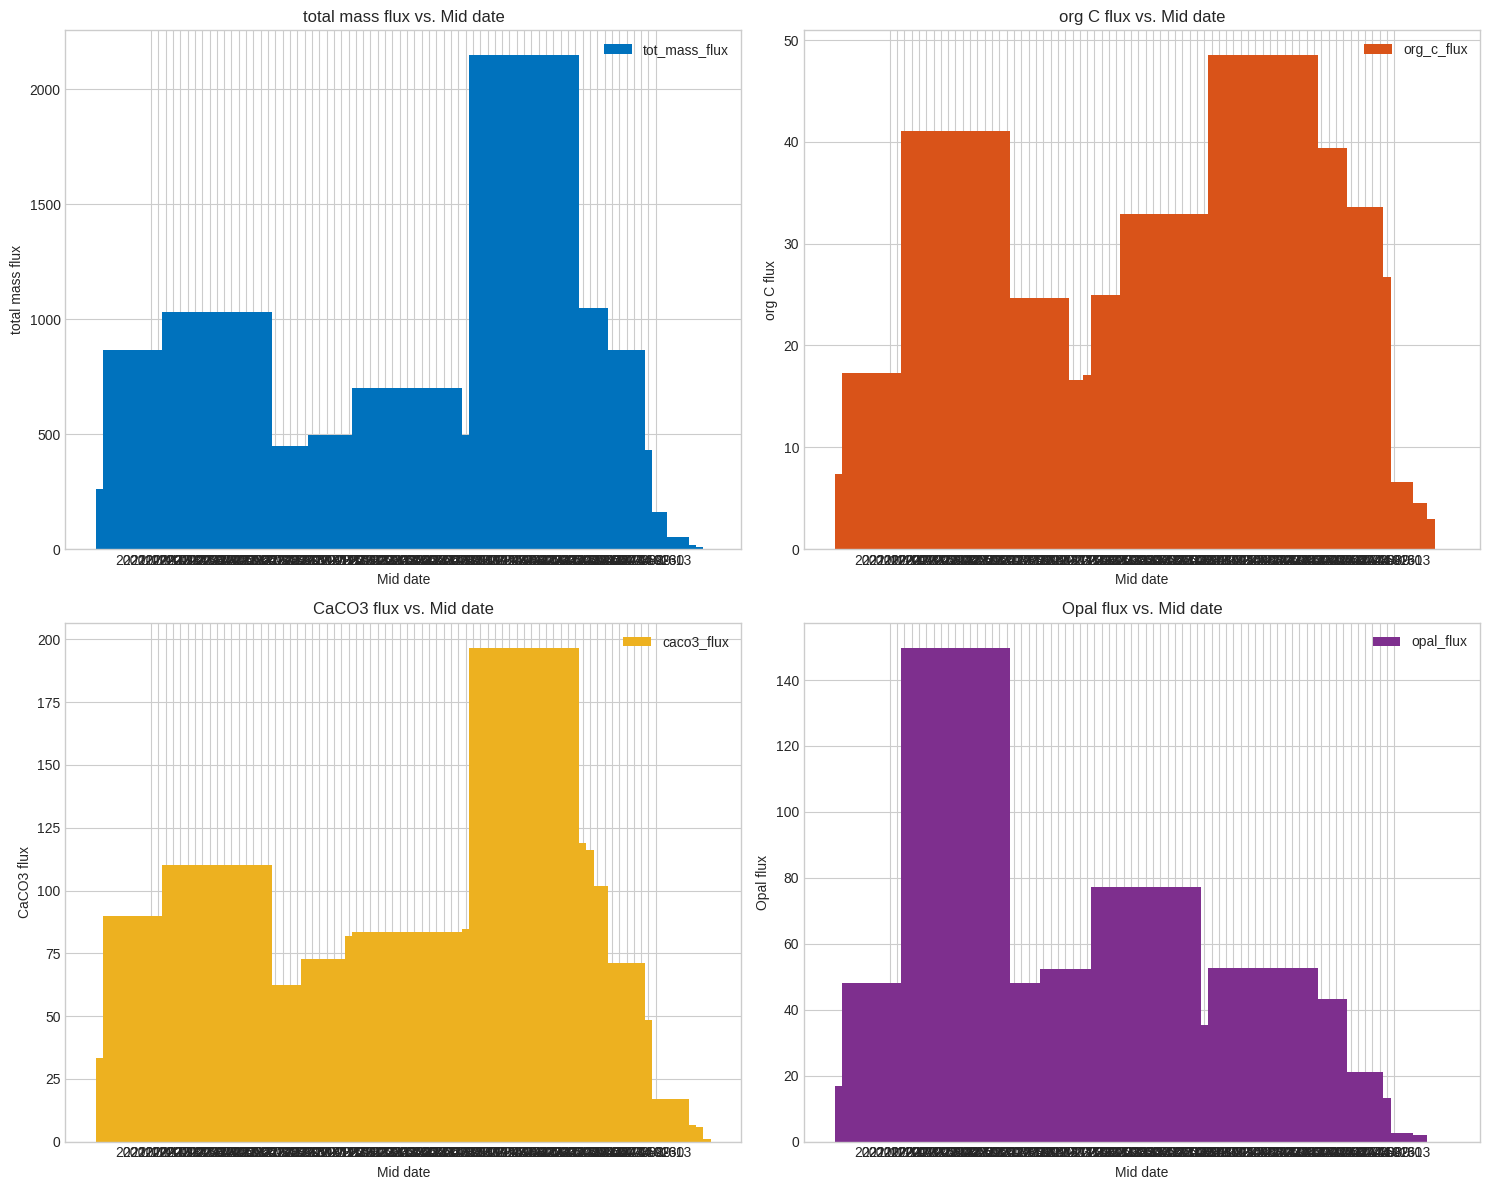

In [23]:
if 'trap_flux_tbl' in locals() and not trap_flux_tbl.empty and 'Mid-Date' in trap_flux_tbl.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # MATLAB Colors [R G B]
    colors = {
        'blue': [0, 0.4470, 0.7410],
        'red': [0.8500, 0.3250, 0.0980],
        'yellow': [0.9290, 0.6940, 0.1250],
        'purple': [0.4940, 0.1840, 0.5560]
    }

    # Helper function to plot bars safely
    def plot_trap_bar(ax, col_name, ylabel, title, color):
        if col_name in trap_flux_tbl.columns:
            ax.bar(trap_flux_tbl['Mid-Date'], trap_flux_tbl[col_name], 
                   label=col_name, color=color, width=15)
            ax.set_xlabel("Mid date")
            ax.set_ylabel(ylabel)
            ax.set_title(title)
            ax.legend()
        else:
            ax.set_title(f"Column '{col_name}' missing")

    # Total Mass Flux
    plot_trap_bar(axes[0, 0], 'tot_mass_flux', "total mass flux", "total mass flux vs. Mid date", colors['blue'])

    # Organic Carbon Flux
    plot_trap_bar(axes[0, 1], 'org_c_flux', "org C flux", "org C flux vs. Mid date", colors['red'])

    # CaCO3 Flux
    plot_trap_bar(axes[1, 0], 'caco3_flux', "CaCO3 flux", "CaCO3 flux vs. Mid date", colors['yellow'])

    # Opal Flux
    plot_trap_bar(axes[1, 1], 'opal_flux', "Opal flux", "Opal flux vs. Mid date", colors['purple'])

    plt.tight_layout()
    plt.show()
else:
    print("Trap flux data or 'Mid_Date' column not available for plotting.")
